# DrivenData Pump it Up Competition

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import functions as fct
from vecstack import stacking
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.special import boxcox1p
from sklearn.decomposition import PCA
from geopy.distance import great_circle
from pandas.api.types import CategoricalDtype
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score as metric_scorer
from scipy.stats import skew, boxcox_normmax, chi2_contingency
from sklearn.feature_selection import RFE, SelectFromModel, RFECV
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer, PowerTransformer, LabelEncoder

import warnings
warnings.filterwarnings('ignore')

## Setting Key Values

TOTSET8 is a cleaned version of the whole dataset. Funder and installer have been cleaned, date-components have been extracted and precipitaion 

In [2]:
SEED = 1
# Train X
DATA_PATH = 'TOTSET8.csv'
# Submission Format
DATA_PATH4 = 'SubmissionFormat.csv'
TARGET_VARIABLE = 'status_group'
SPLITS = 5
ESTIMATORS = 50
MAX_ITER = 500
#For metric, import the required library as metric_scorer
METRIC = 'accuracy'

## Data Reading
Here we read the data, print its first rows and describe its contents

In [3]:
def read_data(input_path):
    return pd.read_csv(input_path, parse_dates=[1])

tot_data = read_data(DATA_PATH)
submission = read_data(DATA_PATH4)

tot_data.head()

,id,funder,funder_cleaned,installer,installer_cleaned,4sameifone,3sameifone,2sameifone,1sameifone,amount_tsh,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pr,tas
0,69572,Roman,roman church,Roman,roman church,True,True,True,True,6000.0,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,101.776,23.4426
1,8776,Grumeti,grumet,GRUMETI,grumet,True,True,True,False,0.0,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,157.643,23.7156
2,34310,Lottery Club,lottery club,World vision,world vision,False,False,False,False,25.0,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,157.643,23.7156
3,67743,Unicef,unicef,UNICEF,unicef,True,True,True,False,0.0,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,157.643,23.7156
4,19728,Action In A,action in a,Artisan,atisan,False,False,False,False,0.0,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,101.776,23.4426


We review the data types for each column

In [4]:
tot_data.dtypes

id                         int64
funder                    object
funder_cleaned            object
installer                 object
installer_cleaned         object
4sameifone                  bool
3sameifone                  bool
2sameifone                  bool
1sameifone                  bool
amount_tsh               float64
date_recorded             object
date                      object
Year                       int64
MY                        object
Month                      int64
gps_height                 int64
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_man

We check if there is any missing data

In [5]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(tot_data).head(10)

,Total,Percent
scheme_name,35258,0.474855
status_group,14850,0.200000
scheme_management,4846,0.065266
installer_cleaned,4535,0.061077
installer,4532,0.061037
funder_cleaned,4504,0.060660
public_meeting,4155,0.055960
permit,3793,0.051084
subvillage,470,0.006330
tas,0,0.000000


We drop certainly unnecessary columns

In [6]:
def drop_columns(df, cols):
    df.drop(df[cols], axis=1, inplace = True)
    return df

tot_data = drop_columns(tot_data, ['recorded_by', '4sameifone', '3sameifone', '2sameifone', '1sameifone', 'date_recorded'])
submission = drop_columns(submission, ['status_group'])

## Data Preparation

### Converting Columns to their true type
Now fixing the data types of object columns that are actually categorical and of dates

In [7]:
def categoricals(df, exclude = None):
    categorical = df.select_dtypes(include=['category', object])
    excluded = [TARGET_VARIABLE]
    if exclude:
        for i in exclude:
            excluded.append(i)
    cols = [col for col in categorical.columns if col not in excluded]
    return df[cols]

In [8]:
def convert_to_category(df, cols):
    for i in cols:
        df[i] = df[i].astype('category')
    return df

tot_data = convert_to_category(tot_data, categoricals(tot_data))

tot_data.dtypes

id                          int64
funder                   category
funder_cleaned           category
installer                category
installer_cleaned        category
amount_tsh                float64
date                     category
Year                        int64
MY                       category
Month                       int64
gps_height                  int64
longitude                 float64
latitude                  float64
wpt_name                 category
num_private                 int64
basin                    category
subvillage               category
region                   category
region_code                 int64
district_code               int64
lga                      category
ward                     category
population                  int64
public_meeting           category
scheme_management        category
scheme_name              category
permit                   category
construction_year           int64
extraction_type          category
extraction_typ

## Scale and fix skewness

In [9]:
def numericals(df, exclude = None):
    numerical = df.select_dtypes(include=[np.number])
    excluded = [TARGET_VARIABLE]
    if exclude:
        for i in exclude:
            excluded.append(i)
    cols = [col for col in numerical.columns if col not in excluded]
    return df[cols]

Fill zeros in construction year with rounded mean and create dummy indicating previous zeros

In [10]:
tot_data['missing_construction_year'] = (tot_data['construction_year']==0)
tot_data['construction_year'][tot_data['construction_year'] == 0] = -1

In [11]:
tot_data.construction_year.head()

0    1999
1    2010
2    2009
3    1986
4      -1
Name: construction_year, dtype: int64

Standardize the numerical variables

In [12]:
pt = PowerTransformer(method='yeo-johnson', standardize = True).fit(numericals(tot_data[~pd.isna(tot_data['status_group'])], ['id']))
tot_data[numericals(tot_data, ['id']).columns] = pt.transform(numericals(tot_data, ['id']))
tot_data.head()

,id,funder,funder_cleaned,installer,installer_cleaned,amount_tsh,date,Year,MY,Month,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pr,tas,missing_construction_year
0,69572,Roman,roman church,Roman,roman church,1.743682,2011-01-14T00:03:00.000Z,-0.963404,1/2011,0.0,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,-0.832619,-0.471799,False
1,8776,Grumeti,grumet,GRUMETI,grumet,-0.647745,2013-01-06T00:03:00.000Z,1.129149,1/2013,0.0,...,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1.202022,1.052600,False
2,34310,Lottery Club,lottery club,World vision,world vision,1.302939,2013-01-25T00:02:00.000Z,1.129149,1/2013,0.0,...,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,1.202022,1.052600,False
3,67743,Unicef,unicef,UNICEF,unicef,-0.647745,2013-01-28T00:01:00.000Z,1.129149,1/2013,0.0,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,1.202022,1.052600,False
4,19728,Action In A,action in a,Artisan,atisan,-0.647745,2011-01-13T00:07:00.000Z,-0.963404,1/2011,0.0,...,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,-0.832619,-0.471799,True


In [13]:
data = tot_data[~pd.isna(tot_data['status_group'])].copy()

test = tot_data[pd.isna(tot_data['status_group'])].copy()

data.head()

,id,funder,funder_cleaned,installer,installer_cleaned,amount_tsh,date,Year,MY,Month,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pr,tas,missing_construction_year
0,69572,Roman,roman church,Roman,roman church,1.743682,2011-01-14T00:03:00.000Z,-0.963404,1/2011,0.0,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,-0.832619,-0.471799,False
1,8776,Grumeti,grumet,GRUMETI,grumet,-0.647745,2013-01-06T00:03:00.000Z,1.129149,1/2013,0.0,...,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1.202022,1.052600,False
2,34310,Lottery Club,lottery club,World vision,world vision,1.302939,2013-01-25T00:02:00.000Z,1.129149,1/2013,0.0,...,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,1.202022,1.052600,False
3,67743,Unicef,unicef,UNICEF,unicef,-0.647745,2013-01-28T00:01:00.000Z,1.129149,1/2013,0.0,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,1.202022,1.052600,False
4,19728,Action In A,action in a,Artisan,atisan,-0.647745,2011-01-13T00:07:00.000Z,-0.963404,1/2011,0.0,...,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,-0.832619,-0.471799,True


## Plotting the target variable

In [14]:
data['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

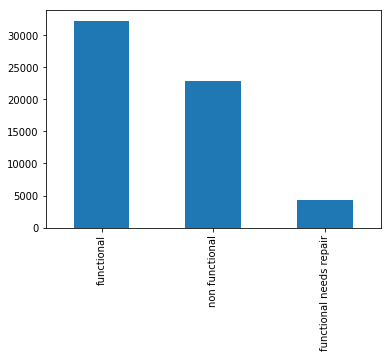

In [15]:
data['status_group'].value_counts().plot(kind='bar')

## Explore distribution of target variable for missing values

In [16]:
vars_with_nan = ['scheme_name', 'scheme_management', 'installer', 'funder', 
                    'public_meeting', 'public_meeting', 'subvillage']

missing_vals = data[vars_with_nan]

In [17]:
mv = pd.DataFrame()
    
mv['overall'] = [len(data[data['status_group'] == 'functional'])/len(data),
                len(data[data['status_group'] == 'non functional'])/len(data),
                len(data[data['status_group'] == 'functional needs repair'])/len(data)]

for col in ['scheme_name', 'scheme_management', 'installer', 'funder', 
                    'public_meeting', 'public_meeting', 'subvillage']:
    mv[col] = [(data[data['status_group'] == 'functional'][col].isnull().sum())/(data[col].isnull().sum()),
              (data[data['status_group'] == 'non functional'][col].isnull().sum())/(data[col].isnull().sum()),
              (data[data['status_group'] == 'functional needs repair'][col].isnull().sum())/(data[col].isnull().sum())]

mv = mv.rename({0: 'functional', 1: 'non functional', 2: 'functional needs repair'})
mv

,overall,scheme_name,scheme_management,installer,funder,public_meeting,subvillage
functional,0.543081,0.514379,0.483105,0.547196,NaN,0.503299,0.552561
non functional,0.384242,0.414471,0.459376,0.332421,NaN,0.449910,0.444744
functional needs repair,0.072677,0.071150,0.057519,0.120383,NaN,0.046791,0.002695


How to read the table: Overall, 38.42% of missing values are for non-functional pumps. However, of all missing values for scheme_management, 45.93% are for non-functional pumps.

Missing values appear to contain information regarding whether a pump is funcional

### Plots

**Distribution of contruction year**

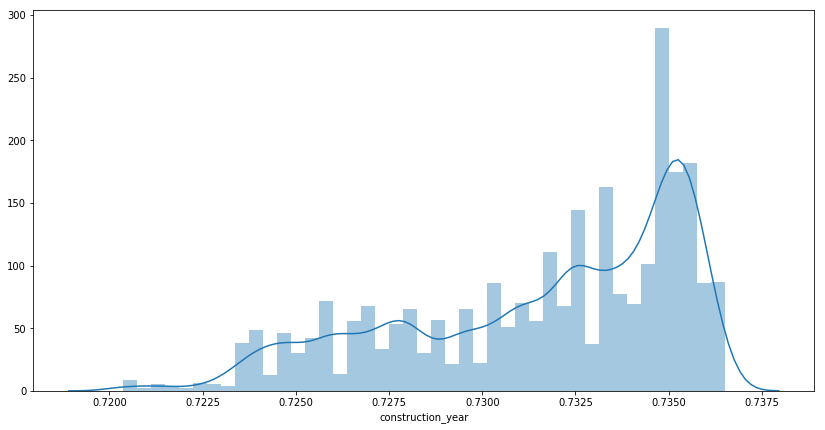

In [18]:
plt.figure(figsize=(14,7))
sns.distplot(data['construction_year'][data['construction_year']>0])

**Distribution of target levels depending on altitude**

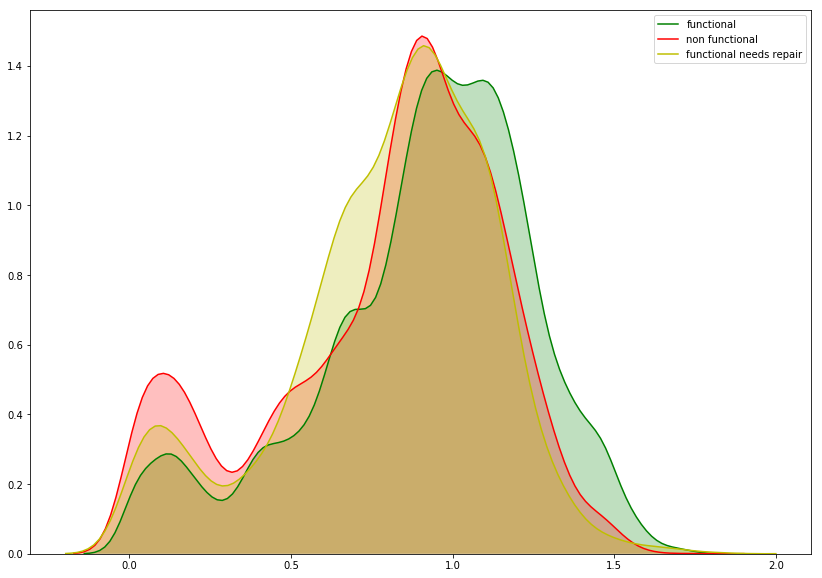

In [19]:
plt.figure(figsize=(14,10))

p1=sns.kdeplot(data[['gps_height','status_group']][data.status_group == 'functional']\
               [data.gps_height > 0].gps_height, shade=True, color="g",label='functional')
p1=sns.kdeplot(data[['gps_height','status_group']][data.status_group == 'non functional']\
               [data.gps_height > 0].gps_height, shade=True, color="r",label='non functional')
p1=sns.kdeplot(data[['gps_height','status_group']][data.status_group == 'functional needs repair']\
               [data.gps_height > 0].gps_height, shade=True, color="y",label='functional needs repair')

**Does the distribution of functional/non functional/non functional needs repair depend on the region?**

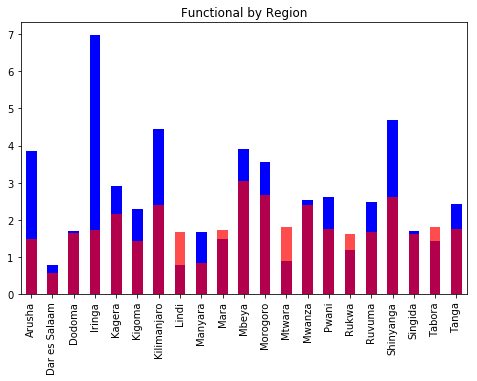

In [20]:
plt.figure(figsize=(8,5))
((data[data.status_group=='functional'].region.value_counts().sort_index()/len(data.status_group))*100).plot(kind='bar',color='b')
((data[data.status_group=='non functional'].region.value_counts().sort_index()/len(data.status_group))*100).plot(kind='bar',color='r',alpha=0.7, title = 'Functional by Region')

### One Hot Encode vs Label Encode

Define function for one hot encoding; it is used later. For the baseline, categorical variables are label-encoded in order to be able to include all of them.

In [21]:
def one_hot_encode(df, cols):
    initialColumns = set(df)
    
    for i in cols:
        dummies = pd.get_dummies(df[i], prefix=i, drop_first = False)
        df = pd.concat([df, dummies], axis = 1)
        df = df.drop(i, axis = 1)
    
    df = convert_to_category(df, set(df) - initialColumns)
    return df

encoded = tot_data.copy()
encoded[categoricals(tot_data, ['status_group']).columns] = categoricals(tot_data, ['status_group']).astype(str).apply(LabelEncoder().fit_transform)

data = encoded[~pd.isna(encoded['status_group'])].copy()

test = encoded[pd.isna(encoded['status_group'])].copy()

encoded.head()

,id,funder,funder_cleaned,installer,installer_cleaned,amount_tsh,date,Year,MY,Month,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pr,tas,missing_construction_year
0,69572,1548,1476,1706,1379,1.743682,104,-0.963404,3,0.0,...,1,8,6,0,1,1,functional,-0.832619,-0.471799,False
1,8776,522,499,610,507,-0.647745,297,1.129149,5,0.0,...,2,5,3,1,1,1,functional,1.202022,1.052600,False
2,34310,924,877,2296,1832,1.302939,353,1.129149,5,0.0,...,1,0,1,1,2,1,functional,1.202022,1.052600,False
3,67743,1961,1858,2078,1704,-0.647745,361,1.129149,5,0.0,...,0,3,0,0,2,1,non functional,1.202022,1.052600,False
4,19728,20,18,133,103,-0.647745,100,-0.963404,3,0.0,...,3,5,3,1,1,1,functional,-0.832619,-0.471799,True


## Baseline

Score a baseline with logistic regression including all variables

In [22]:
baseline_score, baseline_scores, baseline_model = fct.cv_evaluate(data, splits = 3)#, confusion_matrix = True)

print('Best baseline score: \n' + str(baseline_score) + '\n All scores: ' + str(baseline_scores))

Best baseline score: 
0.5420875420875421
 All scores: [0.55023469 0.54117647 0.54138689]


## Feature Engineering

### Add variables

In [23]:
xtra = tot_data.copy()

**Put together some levels**

In [24]:
cleanup = {"extraction_type":{"cemo": 'other motorpump', "climax": 'other motorpump',
                             'other - mkulima/shinyanga': 'walimi', 'other - play pump': 'walimi',
                             'other - swn 81': 'swn', 'swn 80': 'swn',
                             'india mark ii': 'india mark', 'india mark iii': 'india mark',
                             'other - swn 81': 'swn', 'swn 80': 'swn'}}

In [25]:
xtra.replace(cleanup, inplace = True)

**Remove underrepresented levels**

In [26]:
def drop_underrepresented(df, columns, threshold):
    for col in columns:
        freq = pd.value_counts(df[col])
        mask = (freq/freq.sum()).lt(threshold)
        colname = col + '_grouped'
        df[colname] = np.where(df[col].isin(freq[mask].index),'Other',df[col])
    return df

Remove levels of installer_cleaned and funder_cleand with less than 1% representation

In [27]:
xtra = drop_underrepresented(xtra, ['installer_cleaned', 'funder_cleaned'], 0.01)

**Create geocraphical variables**

Distance from (0,0)

In [28]:
xtra['distance'] = xtra.apply(
    lambda x: great_circle(
        (x['latitude'], x['longitude']),
        (0, 0)
    ).miles,
    axis=1)

Geographical clusters based on KMeans

In [29]:
X_loc=xtra.loc[:,['latitude','longitude']]

id_n=300
kmeans = KMeans(n_clusters=id_n, random_state=0).fit(X_loc)
xtra['cluster_id'] = kmeans.labels_

**Create Date variables**

In [30]:
xtra['date'] = pd.to_datetime(xtra['date'], utc = True)

"Days" since recoded and time since construction

In [31]:
xtra['days_since_recorded'] = pd.to_datetime('2014-01-01', utc = True) - xtra['date']
xtra['days_since_recorded'] = pd.to_numeric(xtra['days_since_recorded'])/100000000

xtra['time_since_construction'] = 2015 - xtra['construction_year']

**Create indicator variables**

Dummies indicating if amount_tsh is zero or if a variable is missing

In [32]:
xtra['amount_tsh_zero'] = ((xtra['amount_tsh'] + 1) == True).astype(int)

xtra['missing_scheme_name'] = (xtra['scheme_name'].isnull() == True)

xtra['missing_installer'] = (xtra['installer_cleaned'].isnull() == True)


xtra['missing_funder'] = (xtra['funder_cleaned'].isnull() == True)

xtra['missing_public_meeting'] = (xtra['public_meeting'].isnull() == True)

xtra['missing_subvillage'] = (xtra['subvillage'].isnull() == True)

In [33]:
xtra.head()

,id,funder,funder_cleaned,installer,installer_cleaned,amount_tsh,date,Year,MY,Month,...,distance,cluster_id,days_since_recorded,time_since_construction,amount_tsh_zero,missing_scheme_name,missing_installer,missing_funder,missing_public_meeting,missing_subvillage
0,69572,Roman,roman church,Roman,roman church,1.743682,2011-01-14 00:03:00+00:00,-0.963404,1/2011,0.0,...,92.870653,161,935710200.0,2014.267731,0,False,False,False,False,False
1,8776,Grumeti,grumet,GRUMETI,grumet,-0.647745,2013-01-06 00:03:00+00:00,1.129149,1/2013,0.0,...,85.566930,230,311038200.0,2014.264403,0,True,False,False,True,False
2,34310,Lottery Club,lottery club,World vision,world vision,1.302939,2013-01-25 00:02:00+00:00,1.129149,1/2013,0.0,...,68.917971,39,294622800.0,2014.264705,0,False,False,False,False,False
3,67743,Unicef,unicef,UNICEF,unicef,-0.647745,2013-01-28 00:01:00+00:00,1.129149,1/2013,0.0,...,143.542134,151,292031400.0,2014.271680,0,True,False,False,False,False
4,19728,Action In A,action in a,Artisan,atisan,-0.647745,2011-01-13 00:07:00+00:00,-0.963404,1/2011,0.0,...,119.232628,140,936571800.0,2016.366858,0,True,False,False,False,False


### Encode categorical variables to continuous

Create a variable for the categorical variables indicating the % of functioning pumps for each level of the categorical variable

In [34]:
xtra_test = xtra[pd.isna(xtra['status_group'])].copy()
xtra_train = xtra[~pd.isna(xtra['status_group'])].copy()

In [35]:
xtra_test.shape

(14850, 60)

In [36]:
def encode_to_continuous(df, df_test, columns, target, targetvalue):
    for col in columns:
        colname = col + '_success'
        
        df[colname] = np.where(df[target].isin([targetvalue]),1 ,0).copy()
        df_grouped = df.groupby([col])[colname].sum()
        df_counter = df.groupby([col]).agg('count')[colname]
        
        success = pd.DataFrame(df_grouped/df_counter)
        success[col] = success.index
        df.drop([colname], inplace = True, axis = 1)
        
        df = df.merge(success, on = col)
        df_test = df_test.merge(success, on = col)
        df_test[colname] = df_test[colname].fillna(df_test[colname].mean())
                
    return df, df_test

Code is commented as the features were leading to major overfitting

In [37]:
#xtra_train, xtra_test = encode_to_continuous(xtra_train, xtra_test, ['ward', 'lga', 'subvillage'], 'status_group', 'functional')

**Selected columns**

Discard columns that belong to the same thing and are hight correlated or that have to many levels

In [38]:
selected_cols = ['amount_tsh', 'Year', 'MY', 'gps_height', 'longitude', 'latitude', 'num_private', 'basin', 'region',
                 'district_code', 'population', 'public_meeting', 'scheme_management', 'permit',
                 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'source_type',
                 'source_class', 'waterpoint_type', 'pr', 'tas', 'missing_construction_year',
                 'installer_cleaned_grouped', 'funder_cleaned_grouped', 'distance', 'cluster_id', 'days_since_recorded',
                 'time_since_construction', 'amount_tsh_zero', 'missing_scheme_name', 'missing_installer', 'missing_funder',
                 'missing_public_meeting', 'missing_subvillage', 'status_group']

In [39]:
xtra_train_selected = xtra_train[selected_cols].copy()
xtra_test_selected = xtra_test[selected_cols].copy()

**Onehot Encode**

In [40]:
xtra_train_dummyfied = one_hot_encode(xtra_train_selected, categoricals(xtra_train_selected))
xtra_test_dummyfied = one_hot_encode(xtra_test_selected, categoricals(xtra_test_selected))

In [41]:
xtra_train_dummyfied.head()

,amount_tsh,Year,gps_height,longitude,latitude,num_private,district_code,population,pr,tas,...,funder_cleaned_grouped_norad,funder_cleaned_grouped_private individual,funder_cleaned_grouped_roman church,funder_cleaned_grouped_rwssp,funder_cleaned_grouped_tasaf,funder_cleaned_grouped_tcrs,funder_cleaned_grouped_unicef,funder_cleaned_grouped_wateraid,funder_cleaned_grouped_world bank,funder_cleaned_grouped_world vision
0,1.743682,-0.963404,0.974640,-0.017877,-1.344013,-0.113616,0.670342,0.746320,-0.832619,-0.471799,...,0,0,1,0,0,0,0,0,0,0
1,-0.647745,1.129149,0.981122,-0.090077,1.235144,-0.113616,-0.505520,1.058946,1.202022,1.052600,...,0,0,0,0,0,0,0,0,0,0
2,1.302939,1.129149,0.380148,0.808415,0.584308,-0.113616,0.410603,1.022130,1.202022,1.052600,...,0,0,0,0,0,0,0,0,0,0
3,-0.647745,1.129149,-0.149872,1.179788,-1.710133,-0.113616,2.287415,0.529916,1.202022,1.052600,...,0,0,0,0,0,0,1,0,0,0
4,-0.647745,-0.963404,-0.944170,-1.047628,1.371361,-0.113616,-1.484429,-1.077493,-0.832619,-0.471799,...,0,0,0,0,0,0,0,0,0,0


Feature ranking:


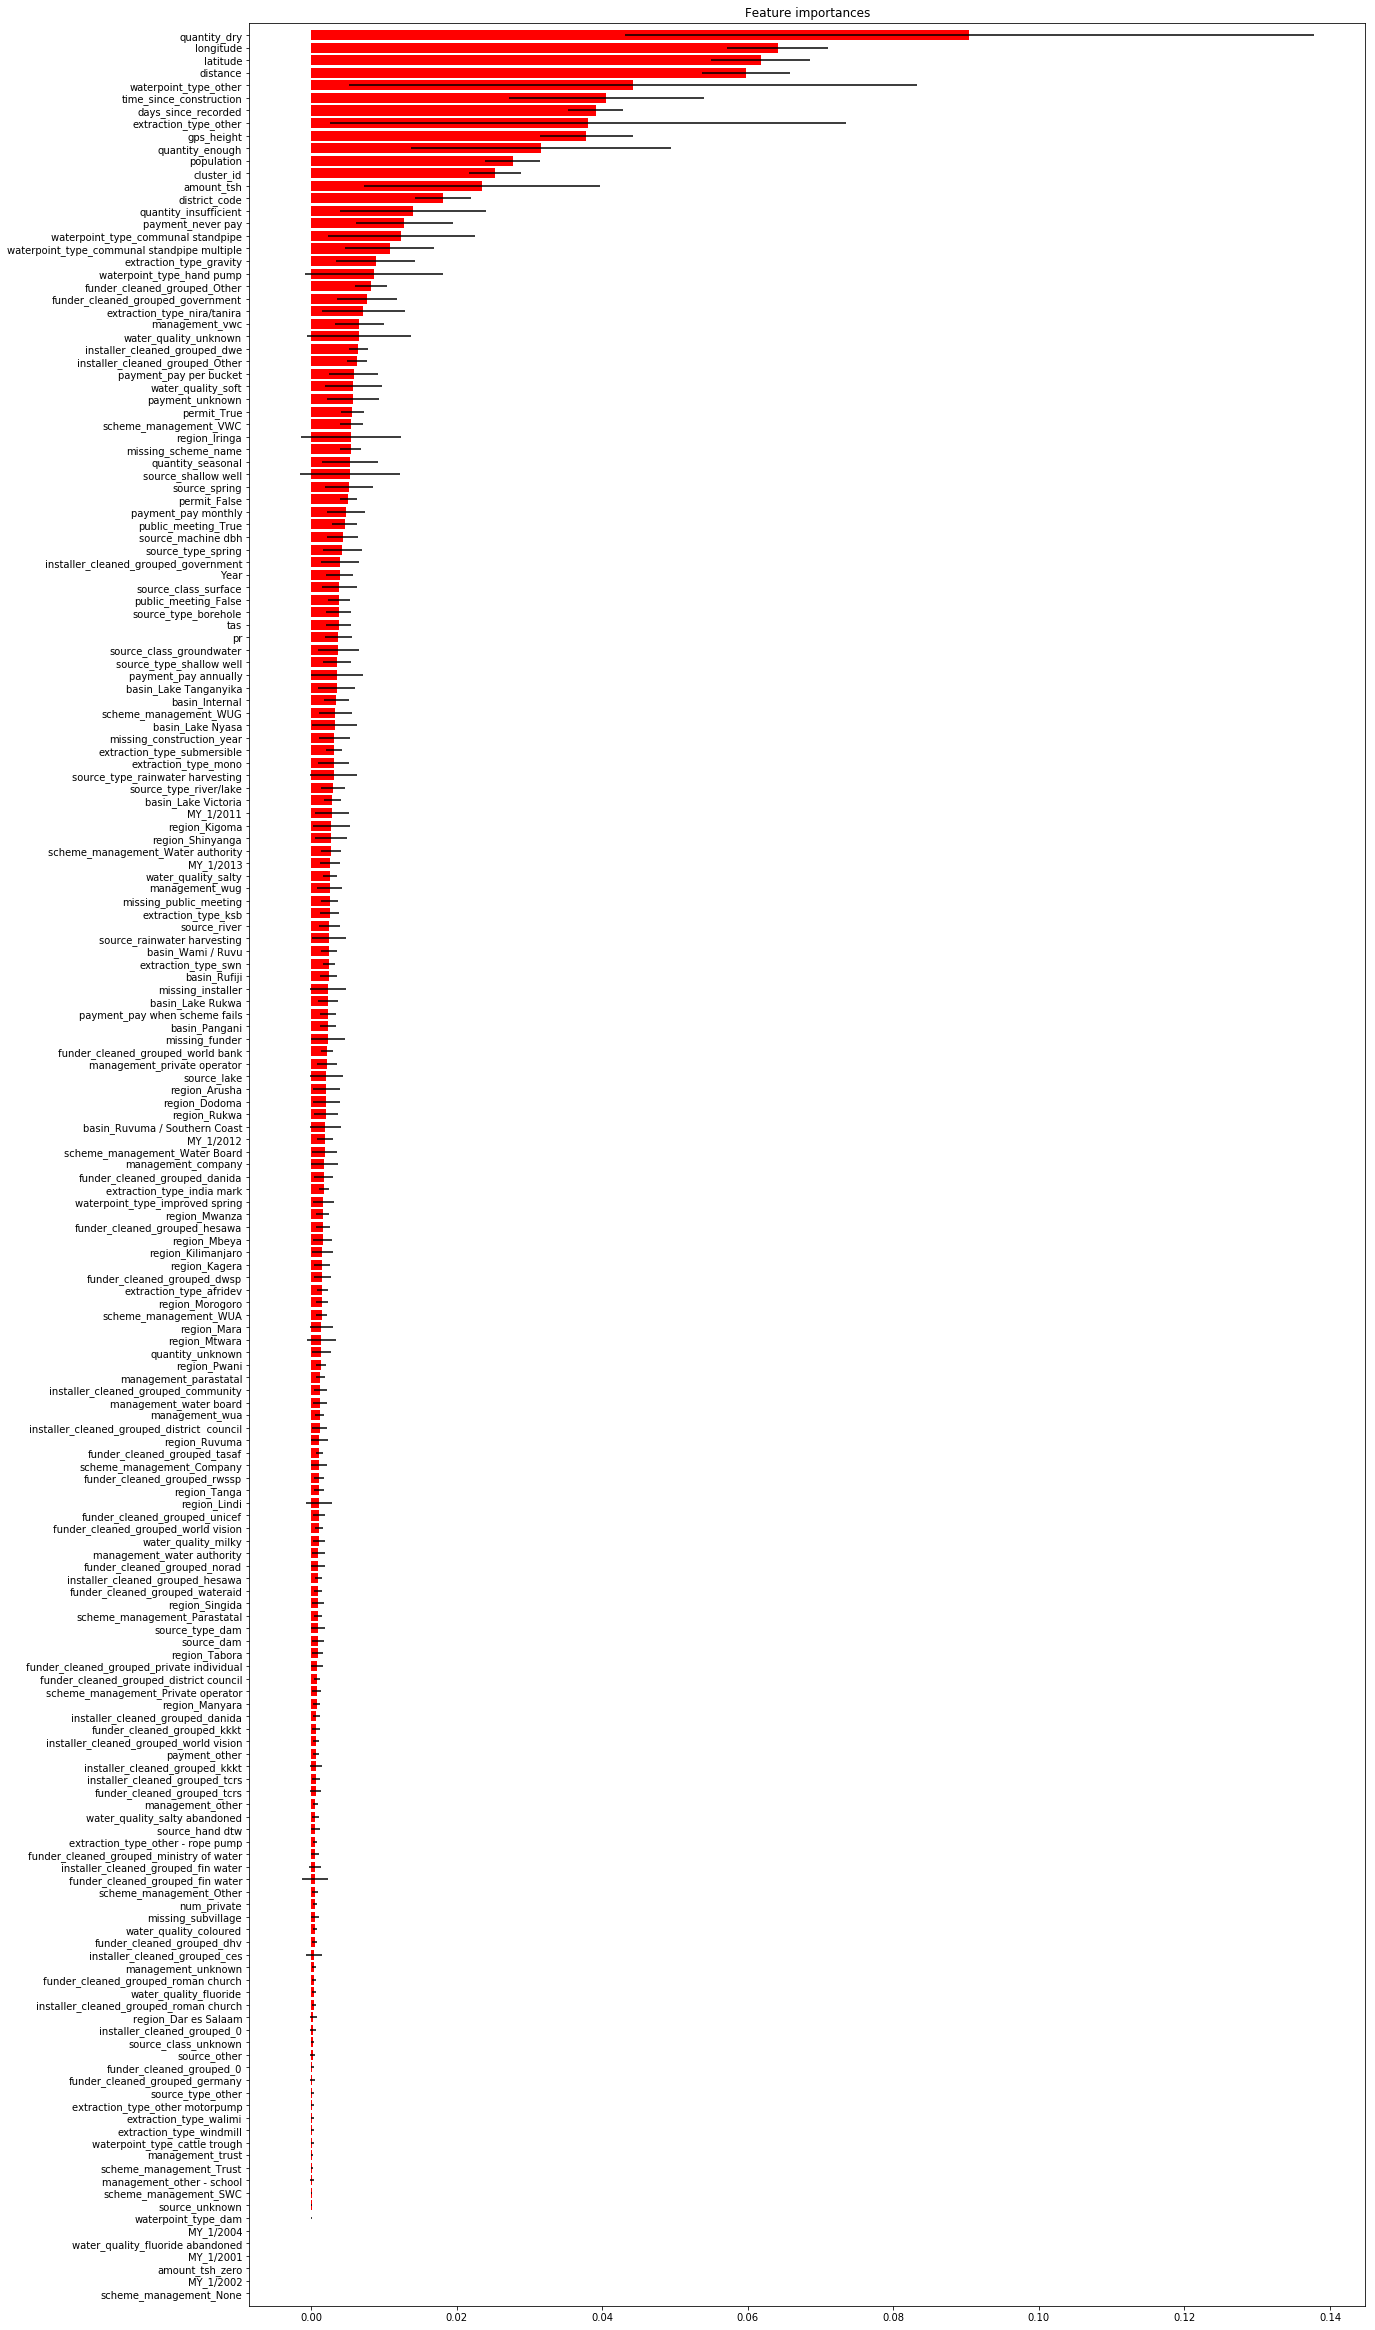

In [43]:
def feature_importance(df, model):
    acc, scores, model = fct.cv_evaluate(df, model = model)
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    indices = np.argsort(importances)
    
    X = df.loc[:, df.columns != TARGET_VARIABLE]
    print("Feature ranking:")
    plt.figure(figsize=(20, 42))
    plt.title("Feature importances")
    plt.barh(range(X.shape[1]), importances[indices],color="r", xerr=std[indices], align="center")
    plt.yticks(range(X.shape[1]), [list(df.loc[:, df.columns != TARGET_VARIABLE])[i] for i in indices])
    plt.ylim([-1, X.shape[1]])
    plt.show()
    
feature_importance(xtra_train_dummyfied, RandomForestClassifier(n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_leaf_nodes=None, max_features= 'auto', max_depth=None, random_state = SEED))

**Select relevant variables through RFE**

In [42]:
trans = RFE(RandomForestClassifier(n_estimators = 10, random_state = 1))

y_train_rfe = xtra_train_dummyfied['status_group'].copy()

X_train_rfe = xtra_train_dummyfied.loc[:, xtra_train_dummyfied.columns != TARGET_VARIABLE]

X_test_rfe = xtra_test_dummyfied.loc[:, xtra_test_dummyfied.columns != TARGET_VARIABLE]

trans.fit(X_train_rfe, y_train_rfe)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=0)

In [43]:
xtra.shape

(74250, 60)

In [44]:
len(trans.support_)

181

In [45]:
prev_data = data.copy()
prev_test = test.copy()

In [46]:
prev_test.shape

(14850, 48)

In [47]:
data = X_train_rfe.iloc[:,trans.support_].copy()
test = X_test_rfe.iloc[:,trans.support_].copy()

In [48]:
data['status_group'] = prev_data['status_group'].copy()

In [49]:
data.shape

(59400, 91)

Which are the variables selected?

In [50]:
data.dtypes

amount_tsh                                      float64
Year                                            float64
gps_height                                      float64
longitude                                       float64
latitude                                        float64
district_code                                   float64
population                                      float64
pr                                              float64
tas                                             float64
missing_construction_year                          bool
distance                                        float64
cluster_id                                        int32
days_since_recorded                             float64
time_since_construction                         float64
missing_scheme_name                                bool
missing_installer                                  bool
missing_funder                                     bool
missing_public_meeting                          

#### Perform Randomized Gridsearch on Algorithms used

Random Forest Classifier

In [51]:
grid_rf = {
    'max_depth': [10, 20, 90, None],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5, 20],
    'max_leaf_nodes': [10, 20, 50, None],
    'n_estimators': [10, 50, 100, 500, 1000]
}

rfc_grid = RandomForestClassifier(random_state = SEED)

# Uncomment to run:
#grid_holdout_score, grid_scores, grid_model = fct.cv_evaluate(data, model = rfc_grid, grid = grid_rf)
#score = {'Model': 'RandomForest', 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(grid_scores[grid_scores > 0.0]),np.std(grid_scores[grid_scores > 0.0])), 'Holdout Score': "{0:.3f}".format(grid_holdout_score), 'Difference': 0, 'Outcome': 'Final Cross Validation'}

Results:

{'Model': 'RandomForest',
 'Function': 'cross_evaluate',
 'CV Score': '0.726 +/- 0.021',
 'Holdout Score': '0.811',
 'Difference': 0,
 'Outcome': 'Final Cross Validation'}
 
 {'n_estimators': 10,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_leaf_nodes': None,
 'max_features': 'auto',
 'max_depth': None}

Gradient Boosting Classifier

In [52]:
grid_gbt = {
    'learning_rate': [0.05, 0.1, 0.3],
    'n_estimators': [50, 100, 500],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 5, 20],
    'max_depth': [2, 3, 5]
}

gbt_grid = GradientBoostingClassifier(random_state = SEED)

# Uncomment to run
#grid_holdout_score3, grid_scores3, grid_model3 = fct.cv_evaluate(data, model = gbt_grid, grid = grid_gbt)
#score3 = {'Model': 'GradientBoosingClassifier', 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(grid_scores3[grid_scores3 > 0.0]),np.std(grid_scores3[grid_scores3 > 0.0])), 'Holdout Score': "{0:.3f}".format(grid_holdout_score3), 'Difference': 0, 'Outcome': 'Final Cross Validation'}

Results:

{'Model': 'GradientBoostingClassifier',
 'Function': 'cross_evaluate',
 'CV Score': '0.757 +/- 0.026',
 'Holdout Score': '0.800',
 'Difference': 0,
 'Outcome': 'Final Cross Validation'}
 
{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'learning_rate': 0.3}

## Running the pipeline

In [53]:
MAX_ITER = 1300

In [54]:
models = [
#     {'name':'logistic_regression', 'model': LogisticRegression(multi_class = 'ovr', solver = 'lbfgs', max_iter = MAX_ITER)},
#    {'name':'random_forest', 'model': RandomForestClassifier(n_estimators=50, random_state = SEED)},
    {'name':'random_forest_tuned', 'model': RandomForestClassifier(n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_leaf_nodes=None, max_features= 'auto', max_depth=None, random_state = SEED)},
#    {'name':'gradient_boosting', 'model': GradientBoostingClassifier(n_estimators = 50, random_state = SEED)},
    {'name':'gradient_boosting_tuned', 'model': GradientBoostingClassifier(n_estimators = 100, min_samples_split=2, min_samples_leaf=2, max_depth=5,learning_rate=0.3, random_state = SEED)}
]

transformers = [
#     {'name':'rfe', 'transformer': RFE(LogisticRegression(multi_class = 'ovr', solver = 'lbfgs', max_iter = MAX_ITER))},
#     {'name':'rfe', 'transformer': RFE(RandomForestRegressor(random_state = SEED))},
#     {'name':'feature_selection', 'transformer': SelectFromModel(LogisticRegression(multi_class = 'ovr', solver = 'lbfgs', max_iter = MAX_ITER))},
#     {'name':'feature_selection', 'transformer': SelectFromModel(RandomForestRegressor(random_state = SEED))},
#     {'name':'binning', 'transformer': KBinsDiscretizer(n_bins=5, encode='onehot')},
#     {'name':'binning', 'transformer': KBinsDiscretizer(n_bins=6, encode='onehot')},
#     {'name':'polynomial', 'transformer': PolynomialFeatures(degree=2, include_bias=False)},
#     {'name':'polynomial', 'transformer': PolynomialFeatures(degree=3, include_bias=False)},
#     {'name':'pca', 'transformer': PCA(.90)},
#     {'name':'pca', 'transformer': PCA(.95)},
#     {'name':'gp', 'transformer': SymbolicTransformer(population_size=750, metric='spearman', function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min', 'sin', 'cos', 'tan'],parsimony_coefficient=0.0005,max_samples=0.9,random_state=SEED)}
]

pipelines, all_scores = fct.feature_engineering_pipeline(data, models, transformers, SPLITS)

In [55]:
all_scores

,Model,Function,CV Score,Holdout Score,Difference,Outcome
0,random_forest_tuned,base_score,0.81 +/- 0.0026,0.807520,0,Base random_forest_tuned
1,gradient_boosting_tuned,base_score,0.80 +/- 0.0023,0.796072,0,Base gradient_boosting_tuned


### Create stacked model based on the obtained models

The stacked model stacks the best two models from the pipeline plus a One vs Rest classifier with the best model from the pipeline inside and fits them to the train data. The results of these models are then fed into the best model from the initial baseline (as training data), and a prediction is done on the test set.

In [56]:
models = [
    OneVsRestClassifier(pipelines[0]['pipeline']),
    pipelines[0]['pipeline'],
    pipelines[1]['pipeline']
]

X_train = data.loc[:, data.columns != TARGET_VARIABLE]
y_train = data['status_group'].copy()
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)

X_test = test.loc[:, test.columns != TARGET_VARIABLE]


S_train, S_test = stacking(
    models,                   
    X_train,
    y_train,
    X_test,  
    regression=False, 
    mode='oof_pred_bag', 
    needs_proba=False,
    save_dir=None, 
    metric=METRIC, 
    n_folds=4, 
    stratified=True,
    shuffle=True,  
    random_state=SEED
)

final_model = pipelines[0]['model']
final_model.fit(S_train, y_train)
X_test[TARGET_VARIABLE] = le.inverse_transform(final_model.predict(S_test))

X_test['id'] = prev_test['id'].copy()

submission_1 = submission.copy()
submission_1 = submission_1.merge(X_test, on = 'id', how = 'left', suffixes = ('',''))

In [57]:
submission_1[['id', 'status_group']].to_csv('predictions_final.csv', sep=',', index = False)

<img src="files/score.jpeg">